## 데이터셋 다운로드 및 Dependency 설치

In [ ]:
# 데이터셋을 노트북 파일과 동일한 경로에 다운로드했다는 전제 하에 진행
#
# Kaggle에서 토큰 다운로드 받아 ~/.kaggle/kaggle.json에 저장
# pip install kaggle
# chmod 600 ~/.kaggle/kaggle.json
# kaggle competitions download -c deeplearningchallenge
# unzip deeplearningchallenge.zip

In [1]:
%pip install numpy pandas pyarrow transformers tqdm torchvision decord cfscrape accelerate einops timm flash-attn 'urllib3<2'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 81.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 64.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.0/802.0 kB 76.1 MB/s eta 0:00:00
  DEPRECATION: Building 'flash-attn' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interfa

In [2]:
%pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 90.3 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip freeze > requirements.txt

with open('requirements.txt', 'r', encoding='utf-8') as f:
    requirements = f.read()
    print(requirements)

Note: you may need to restart the kernel to use updated packages.
accelerate==1.10.1
asttokens==3.0.0
attrs==25.3.0
backcall==0.2.0
beautifulsoup4==4.13.5
bitsandbytes==0.47.0
bleach==6.2.0
certifi==2025.6.15
cfscrape==2.1.1
charset-normalizer==3.4.2
comm==0.2.2
debugpy==1.8.14
decorator==5.2.1
decord==0.6.0
defusedxml==0.7.1
docopt==0.6.2
einops==0.8.1
executing==2.2.0
fastjsonschema==2.21.2
filelock==3.18.0
flash_attn==2.8.3
fsspec==2025.5.1
hf-xet==1.1.5
huggingface-hub==0.34.4
idna==3.10
inquirerpy==0.3.4
ipykernel==6.29.5
ipython==8.12.3
ipython_pygments_lexers==1.1.1
ipywidgets==8.1.7
jedi==0.19.2
Jinja2==3.1.4
jsonschema==4.25.1
jsonschema-specifications==2025.4.1
jupyter_client==8.6.3
jupyter_core==5.8.1
jupyterlab_pygments==0.3.0
jupyterlab_widgets==3.0.15
MarkupSafe==2.1.5
matplotlib-inline==0.1.7
mistune==3.1.4
mpmath==1.3.0
nbclient==0.10.2
nbconvert==7.16.6
nbformat==5.10.4
nest-asyncio==1.6.0
networkx==3.3
numpy==2.1.2
nvidia-cublas-cu12==12.8.3.14
nvidia-cuda-cupti-cu12=

## 데이터셋 및 모델 로드

**WARNING!**

**아래 코드 실행 전 커널 재시작 필요!**

In [8]:
import os
import requests

import numpy as np
import pandas as pd
import pyarrow
from tqdm import tqdm
import accelerate

import torch
import base64
from io import BytesIO
from PIL import Image
from transformers import AutoModel, AutoTokenizer

In [ ]:
test_path = './deep_chal_multitask_dataset_test.parquet'
test = pd.read_parquet(test_path, engine='pyarrow')

In [ ]:
test.head(10)

,input_type,task,input,question
0,image,captioning,/9j/4AAQSkZJRgABAQEBLAEsAAD/4RyhRXhpZgAATU0AKg...,
1,image,captioning,/9j/4AAQSkZJRgABAgEBLAEsAAD/7RSCUGhvdG9zaG9wID...,
2,image,captioning,/9j/4AAQSkZJRgABAQEBLAEsAAD/4Ql1aHR0cDovL25zLm...,
3,image,captioning,/9j/4AAQSkZJRgABAQEBLAEsAAD/4REKRXhpZgAATU0AKg...,
4,image,captioning,/9j/4AAQSkZJRgABAQEBLAEsAAD/2wBDAAIBAQEBAQIBAQ...,
5,image,captioning,/9j/4AAQSkZJRgABAQEASABIAAD//gAyUHJvY2Vzc2VkIE...,
6,image,captioning,/9j/4AAQSkZJRgABAgEASABIAAD/4hxtSUNDX1BST0ZJTE...,
7,image,captioning,/9j/4AAQSkZJRgABAQEBLAEsAAD/2wBDAAIBAQEBAQIBAQ...,
8,image,captioning,/9j/4AAQSkZJRgABAgEBLAEsAAD/7RKSUGhvdG9zaG9wID...,
9,image,captioning,/9j/4AAQSkZJRgABAQAAAQABAAD/4gxYSUNDX1BST0ZJTE...,


In [4]:
path = "OpenGVLab/InternVL3_5-8B"

model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    load_in_8bit=True,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True).eval()

tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True, use_fast=False)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## 입력 데이터 전처리

In [9]:
import math, time, random
import cfscrape
import torchvision.transforms as T
# from decord import VideoReader, cpu
from torchvision.transforms.functional import InterpolationMode

In [10]:
# OpenGVLab/InternVL3_5-8B 모델을 위한 전처리 함수

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    image = image_file # Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

In [11]:
question_template = {
    'captioning' : '\n\n## Instruction: Describe what you see in this image in detail. Start your description with "The image is" or "The image shows" and provide a comprehensive description including key visual elements, objects, people, settings, style, colors, and any text visible in the image.\n',
    'vqa' : '\n\n## Instruction: Look at the above given image carefully and answer the following question based on what you can see. Provide a direct, concise answer.\n\nQuestion: ',
    'math_reasoning' : '\n\n## Instruction: Solve the above given math problem step by step. Show your work clearly by expressing each calculation in the format <<calculation=result>>. End your response with the final answer in the format "#### {final_answer}".\n',
    'summarization' : '\n\n## Instruction: Read the above given text and provide a concise summary that captures the main purpose, key provisions, and essential details. Focus on the most important information and present it clearly.\n',
    'text_qa' : '\n\n## Instruction: Read the above given passage carefully and answer the question based on the information provided. Give a direct, accurate answer.\n\nQuestion: '
}

headers = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36",
    "Referer": "https://pulpcovers.com/"
}

def preprocess(row):
    input_type = row['input_type']
    task = row['task']
    input_value = row['input']
    question = row['question']
    scraper = cfscrape.create_scraper()

    # Set new 'image' column based on input_type
    if input_type == 'image':
        new_image = input_value
        if input_value[:4] == 'http':
            try:
                res = requests.get(input_value, headers=headers, stream=True)
                time.sleep(random.uniform(1.0, 2.0))
                input_value = Image.open(BytesIO(res.content))
            except:
                try:
                    res = scraper.get(input_value, headers=headers, stream=True)
                    time.sleep(random.uniform(1.0, 2.0))
                    input_value = Image.open(BytesIO(res.content))
                except:
                    print(input_value)
        else:
            binary = base64.b64decode(input_value)
            file = BytesIO(binary)
            input_value = Image.open(file).convert('RGB')
    else:
        new_image = None
    
    row['input'] = input_value
    row['question'] = question_template[task] + question
    row['image'] = new_image
    return row

def build_messages(test):
    input_messages = []

    for idx, data in tqdm(test.iterrows(), desc='Building messages: '):
        messages = [
            {
                "role": "user",
                "content": [
                    {
                        "type": data.loc['input_type'],
                        data.loc['input_type']: data.loc['input'],
                    },
                    {"type": "text", "text": data.loc['question']},
                ],
            }
        ]

        text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        input_messages.append(text)

    return input_messages

In [11]:
test['task'].value_counts()

task
vqa               500
summarization     500
math_reasoning    500
text_qa           500
captioning        493
Name: count, dtype: int64

In [ ]:
# 전처리(특히 이미지 파일) 진행
# 이미지를 이미 다운로드 받은 것이 아니라면, CF Robot 체크를 피하기 위해 최대 8시간 소요될 수 있음!

tqdm.pandas()
test_pp = test.progress_apply(preprocess, axis=1)

  0%|          | 10/2493 [00:00<01:55, 21.42it/s]/venv/main/lib/python3.12/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (97915360 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
  2%|▏         | 48/2493 [00:05<06:39,  6.12it/s]

https://pulpcovers.com/wp-content/uploads/2011/01/19659982-4064698162790da9c0f8022104e0aead6b819f4a1.jpeg


100%|██████████| 2493/2493 [00:38<00:00, 65.29it/s]  


In [ ]:
# requests 및 cfscrape로 접근할 수 없는 이미지 파일 직접 다운받아 로드

test_pp.iloc[41]['input'] = Image.open('./test-41.jpeg')

/tmp/ipykernel_3202/3339037630.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  test_pp.iloc[41]['input'] = Image.open('./test-41.jpeg')


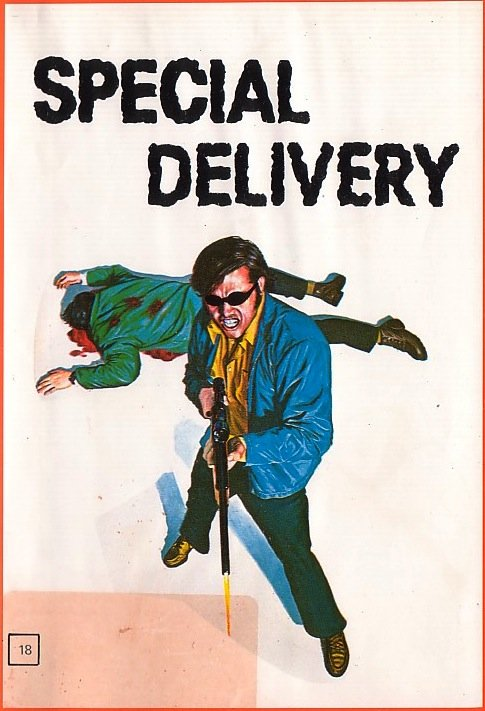

In [45]:
test_pp.iloc[41]['input']

In [21]:
test_pp.iloc[490] = preprocess(test_pp.iloc[490])

In [25]:
test_pp.head()

,input_type,task,input,question,image
0,image,captioning,<PIL.Image.Image image mode=RGB size=1504x1116...,<image>\n\nDescribe what you see in this image...,/9j/4AAQSkZJRgABAQEBLAEsAAD/4RyhRXhpZgAATU0AKg...
1,image,captioning,<PIL.Image.Image image mode=RGB size=1249x2143...,<image>\n\nDescribe what you see in this image...,/9j/4AAQSkZJRgABAgEBLAEsAAD/7RSCUGhvdG9zaG9wID...
2,image,captioning,<PIL.Image.Image image mode=RGB size=2024x2890...,<image>\n\nDescribe what you see in this image...,/9j/4AAQSkZJRgABAQEBLAEsAAD/4Ql1aHR0cDovL25zLm...
3,image,captioning,<PIL.Image.Image image mode=RGB size=2073x3017...,<image>\n\nDescribe what you see in this image...,/9j/4AAQSkZJRgABAQEBLAEsAAD/4REKRXhpZgAATU0AKg...
4,image,captioning,<PIL.Image.Image image mode=RGB size=2280x3157...,<image>\n\nDescribe what you see in this image...,/9j/4AAQSkZJRgABAQEBLAEsAAD/2wBDAAIBAQEBAQIBAQ...


In [ ]:
# 프롬프트 적용 및 완성

def add_image_tag(row):
    if row['input_type'] == 'image':
        row['question'] = '<image>\n' + row['question']
    else:
        row['question'] = row['input'] + '\n' + row['question']
    return row

test_pp.progress_apply(add_image_tag, axis=1)

100%|██████████| 2493/2493 [00:00<00:00, 35267.53it/s]


,input_type,task,input,question,image
0,image,captioning,<PIL.Image.Image image mode=RGB size=1504x1116...,<image>\n\n\n## Instruction: Describe what you...,/9j/4AAQSkZJRgABAQEBLAEsAAD/4RyhRXhpZgAATU0AKg...
1,image,captioning,<PIL.Image.Image image mode=RGB size=1249x2143...,<image>\n\n\n## Instruction: Describe what you...,/9j/4AAQSkZJRgABAgEBLAEsAAD/7RSCUGhvdG9zaG9wID...
2,image,captioning,<PIL.Image.Image image mode=RGB size=2024x2890...,<image>\n\n\n## Instruction: Describe what you...,/9j/4AAQSkZJRgABAQEBLAEsAAD/4Ql1aHR0cDovL25zLm...
3,image,captioning,<PIL.Image.Image image mode=RGB size=2073x3017...,<image>\n\n\n## Instruction: Describe what you...,/9j/4AAQSkZJRgABAQEBLAEsAAD/4REKRXhpZgAATU0AKg...
4,image,captioning,<PIL.Image.Image image mode=RGB size=2280x3157...,<image>\n\n\n## Instruction: Describe what you...,/9j/4AAQSkZJRgABAQEBLAEsAAD/2wBDAAIBAQEBAQIBAQ...
...,...,...,...,...,...
2488,text,text_qa,Alan worked in an office in the city. He worke...,Alan worked in an office in the city. He worke...,None
2489,text,text_qa,The kitchen comes alive at night in the Sander...,The kitchen comes alive at night in the Sander...,None
2490,text,text_qa,A440 or A4 (also known as the Stuttgart pitch)...,A440 or A4 (also known as the Stuttgart pitch)...,None
2491,text,text_qa,"The dog, called Prince, was an intelligent ani...","The dog, called Prince, was an intelligent ani...",None


In [ ]:
# 프롬프트 텍스트만 추출하여 분리

texts = test_pp['question']

In [48]:
texts

0       <image>\n\n\n## Instruction: Describe what you...
1       <image>\n\n\n## Instruction: Describe what you...
2       <image>\n\n\n## Instruction: Describe what you...
3       <image>\n\n\n## Instruction: Describe what you...
4       <image>\n\n\n## Instruction: Describe what you...
                              ...                        
2488    Alan worked in an office in the city. He worke...
2489    The kitchen comes alive at night in the Sander...
2490    A440 or A4 (also known as the Stuttgart pitch)...
2491    The dog, called Prince, was an intelligent ani...
2492    Las Vegas (, Spanish for "The Meadows"), offic...
Name: question, Length: 2493, dtype: object

In [ ]:
## 이미지 정보만 추출하여 분리

image_inputs = test_pp['input']
image_inputs = image_inputs.apply(lambda x: None if isinstance(x, str) else x)

In [50]:
len(image_inputs)

2493

## 추론

In [ ]:
# 실행 GPU 환경 : RTX 6000Ada (48GB)

batch_size = 16
generation_config = dict(max_new_tokens=1024, do_sample=True, eos_token_id=model.config.eos_token_id)

In [53]:
all_output_texts = []

In [54]:
with torch.inference_mode():
    for i in tqdm(range(0, len(image_inputs), batch_size)):
        pixel_values_list = []
        num_patches_list = []

        # 현재 배치 범위
        batch_images = image_inputs[i : i + batch_size]

        for image in batch_images:
            if image is None:
                num_patches_list.append(0)
                continue
            img_pt = load_image(image).to(torch.bfloat16).cuda()
            pixel_values_list.append(img_pt)
            num_patches_list.append(img_pt.size(0))

        questions = texts[i : i + batch_size].to_list()
        pixel_values = torch.cat(pixel_values_list, dim=0) if pixel_values_list else None

        # 모델 추론
        responses = model.batch_chat(
            tokenizer,
            pixel_values,
            num_patches_list=num_patches_list,
            questions=questions,
            generation_config=generation_config
        )

        all_output_texts.extend(responses)

# 최종 결과
output_texts = all_output_texts

  0%|          | 0/156 [00:00<?, ?it/s]/venv/main/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
100%|██████████| 156/156 [3:06:23<00:00, 71.69s/it]


In [55]:
len(output_texts)

2493

In [64]:
output_texts[-2400]

'The image is a vintage book cover for "The Wife Spanker\'s Club" by Larry Preston, priced at $2.25. The cover features a predominantly pink and purple color scheme, with an illustration set against a beige background. \n\nAt the top left corner, there is a small illustration of a female figure, labeled "ABIZARZOOK BB-II." The title "THE WIFE SPANKER\'S CLUB" is prominently displayed in large, bold pink letters, with the author\'s name "By Larry Preston" just below it in black text.\n\nA distinctive feature is the price tag in the top right corner, showing a price of $2.25 and labeled "AN ERIC FOR CULTATION GOLDENSKYPE GLOBAL PRESS." Additionally, there is a logo with the word "GLOBAL PRESS" in a circle.\n\nThe central illustration, framed by a purple border, depicts a scene of intimacy. One woman with long blonde hair is leaning back, kissing another woman with blue hair. Below them, a man with dark hair is lying on his stomach, looking up at the blonde woman.\n\nAt the bottom, the te

## 제출물 생성

In [65]:
submission = pd.DataFrame(output_texts, columns=['output'])
submission.index.name = 'id'
submission.reset_index(inplace=True)

In [66]:
submission.head()

,id,output
0,0,The image is a black-and-white illustration fe...
1,1,"The image is of a vintage book cover titled ""Y..."
2,2,"The image is a vintage magazine cover for ""Det..."
3,3,The image is a cover of a vintage comic book t...
4,4,The image is a vintage poster featuring a woma...


In [67]:
submission.to_csv('submission.csv', index=False)

In [68]:
check_df = pd.read_csv('submission.csv')

In [69]:
check_df.tail()

,id,output
2488,2488,Because he saw an ad in a newspaper and though...
2489,2489,"No, Susan, John's mother, does not believe her..."
2490,2490,violin
2491,2491,Prince found the wallet.
2492,2492,Las Vegas is in the state of Nevada.
